# Customer Churn Prediction & AI Analysis
## INFO-629-686 - Assignment 5
### Student: Anthony Parone
### Date: December 2025

This notebook demonstrates two AI tasks:
1. **AI Task 1**: Random Forest Classification for Customer Churn Prediction
2. **AI Task 2**: Claude LLM for Business Insights and LIME Explanations

## Setup and Imports

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import anthropic
from lime import lime_tabular
import warnings
from getpass import getpass

warnings.filterwarnings('ignore')
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# Get API key from user
print("Please enter your Anthropic API key:")
ANTHROPIC_API_KEY = getpass("API Key: ")
import time
time.sleep(0.5)  # Brief pause for visual feedback
print("✅ API key stored successfully!")
print("\nRun the next cell to load the dataset and train the model.")

Please enter your Anthropic API key:


API Key:  ········


✅ API key stored successfully!

Proceeding to load data...


## AI Task 1: Customer Churn Prediction (Random Forest)
### Load and Preprocess Data

In [19]:
# Load dataset
CSV_FILE = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(CSV_FILE)
    print(f"✅ Dataset loaded: {df.shape[0]} customers, {df.shape[1]} columns")
    print(f"\nChurn distribution:\n{df['Churn'].value_counts()}")
except FileNotFoundError:
    print(f"❌ Error: {CSV_FILE} not found!")
    print("Please download from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
    raise

# Preprocess data
print("\nPreprocessing data...")
df_processed = df.copy()

# Convert TotalCharges to numeric and fill missing values
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
df_processed['TotalCharges'] = df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median())

# Drop customerID
df_processed = df_processed.drop('customerID', axis=1)

# Convert target variable
df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical variables
encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le

print(f"✅ Data preprocessed: {df_processed.shape}")
print(f"✅ Encoded {len(encoders)} categorical features")

✅ Dataset loaded: 7043 customers, 21 columns

Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Preprocessing data...
✅ Data preprocessed: (7043, 20)
✅ Encoded 15 categorical features


### Train Random Forest Model

In [20]:
# Split features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train model
print("\n🤖 Training Random Forest model...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✅ Model training completed!")

Train set: 4930 samples
Test set: 2113 samples

🤖 Training Random Forest model...
✅ Model training completed!


### Evaluate Model Performance

MODEL PERFORMANCE METRICS
Accuracy:  0.7672 (76.72%)
Precision: 0.5457 (54.57%)
Recall:    0.7344 (73.44%)
F1-Score:  0.6261 (62.61%)
ROC-AUC:   0.8400 (84.00%)

CONFUSION MATRIX:
True Negatives:  1209
False Positives: 343
False Negatives: 149
True Positives:  412


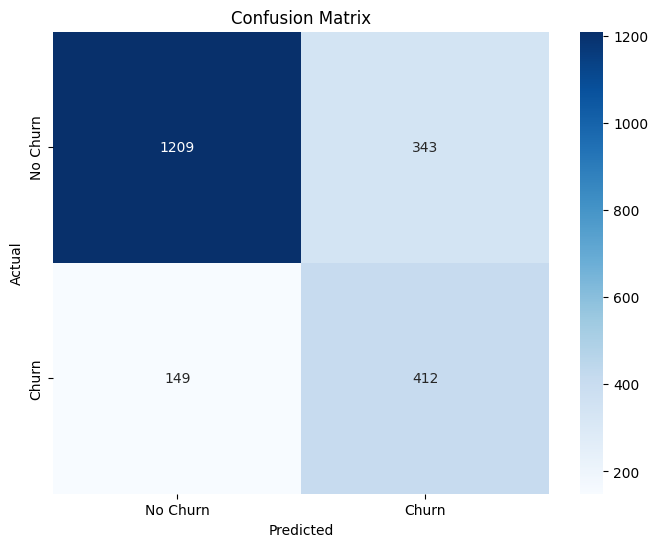

In [21]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")
print("\nCONFUSION MATRIX:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")
print("=" * 60)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Feature Importance Analysis

TOP 10 MOST IMPORTANT FEATURES
 1. Contract                       0.1858
 2. tenure                         0.1469
 3. TotalCharges                   0.1185
 4. MonthlyCharges                 0.1149
 5. OnlineSecurity                 0.0888
 6. TechSupport                    0.0862
 7. InternetService                0.0533
 8. PaymentMethod                  0.0440
 9. OnlineBackup                   0.0295
10. PaperlessBilling               0.0234


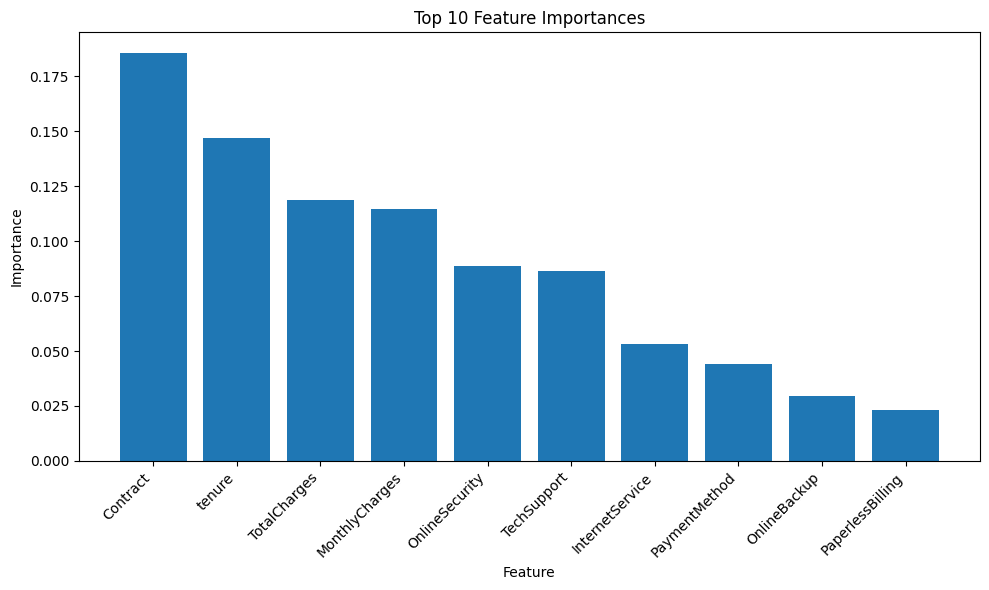

In [22]:
# Get feature importance
feature_names = X.columns.tolist()
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]

print("=" * 60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("=" * 60)
for i, idx in enumerate(indices, 1):
    print(f"{i:2d}. {feature_names[idx]:30s} {importances[idx]:.4f}")
print("=" * 60)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title('Top 10 Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## AI Task 2: Custom Customer Prediction with LIME
### Configure Custom Customer

In [27]:
# Interactive customer configuration with numbered choices
print("=" * 60)
print("CONFIGURE CUSTOM CUSTOMER")
print("Just enter the numbers for each choice!")
print("=" * 60)

# Demographics
print("\n--- DEMOGRAPHICS ---")
print("Gender: 1=Female, 2=Male")
gender_choice = int(input("Enter choice (1 or 2): ").strip())
gender = "Female" if gender_choice == 1 else "Male"

print("\nSenior Citizen: 1=No, 2=Yes")
senior_choice = int(input("Enter choice (1 or 2): ").strip())
senior_citizen = "Yes" if senior_choice == 2 else "No"

print("\nHas Partner: 1=No, 2=Yes")
partner_choice = int(input("Enter choice (1 or 2): ").strip())
partner = "Yes" if partner_choice == 2 else "No"

print("\nHas Dependents: 1=No, 2=Yes")
dependents_choice = int(input("Enter choice (1 or 2): ").strip())
dependents = "Yes" if dependents_choice == 2 else "No"

# Account Information
print("\n--- ACCOUNT INFORMATION ---")
tenure = int(input("Tenure (months, e.g., 12): ").strip())

print("\nContract Type: 1=Month-to-month, 2=One year, 3=Two year")
contract_choice = int(input("Enter choice (1, 2, or 3): ").strip())
contract_map = {1: "Month-to-month", 2: "One year", 3: "Two year"}
contract = contract_map[contract_choice]

print("\nPaperless Billing: 1=No, 2=Yes")
billing_choice = int(input("Enter choice (1 or 2): ").strip())
paperless_billing = "Yes" if billing_choice == 2 else "No"

print("\nPayment Method: 1=Electronic check, 2=Mailed check, 3=Bank transfer (automatic), 4=Credit card (automatic)")
payment_choice = int(input("Enter choice (1, 2, 3, or 4): ").strip())
payment_map = {1: "Electronic check", 2: "Mailed check", 3: "Bank transfer (automatic)", 4: "Credit card (automatic)"}
payment_method = payment_map[payment_choice]

# Services
print("\n--- SERVICES ---")
print("Phone Service: 1=No, 2=Yes")
phone_choice = int(input("Enter choice (1 or 2): ").strip())
phone_service = "Yes" if phone_choice == 2 else "No"

print("\nMultiple Lines: 1=No, 2=Yes, 3=No phone service")
lines_choice = int(input("Enter choice (1, 2, or 3): ").strip())
lines_map = {1: "No", 2: "Yes", 3: "No phone service"}
multiple_lines = lines_map[lines_choice]

print("\nInternet Service: 1=DSL, 2=Fiber optic, 3=No")
internet_choice = int(input("Enter choice (1, 2, or 3): ").strip())
internet_map = {1: "DSL", 2: "Fiber optic", 3: "No"}
internet_service = internet_map[internet_choice]

print("\nOnline Security: 1=No, 2=Yes, 3=No internet service")
security_choice = int(input("Enter choice (1, 2, or 3): ").strip())
security_map = {1: "No", 2: "Yes", 3: "No internet service"}
online_security = security_map[security_choice]

print("\nOnline Backup: 1=No, 2=Yes, 3=No internet service")
backup_choice = int(input("Enter choice (1, 2, or 3): ").strip())
backup_map = {1: "No", 2: "Yes", 3: "No internet service"}
online_backup = backup_map[backup_choice]

print("\nDevice Protection: 1=No, 2=Yes, 3=No internet service")
protection_choice = int(input("Enter choice (1, 2, or 3): ").strip())
protection_map = {1: "No", 2: "Yes", 3: "No internet service"}
device_protection = protection_map[protection_choice]

print("\nTech Support: 1=No, 2=Yes, 3=No internet service")
support_choice = int(input("Enter choice (1, 2, or 3): ").strip())
support_map = {1: "No", 2: "Yes", 3: "No internet service"}
tech_support = support_map[support_choice]

print("\nStreaming TV: 1=No, 2=Yes, 3=No internet service")
tv_choice = int(input("Enter choice (1, 2, or 3): ").strip())
tv_map = {1: "No", 2: "Yes", 3: "No internet service"}
streaming_tv = tv_map[tv_choice]

print("\nStreaming Movies: 1=No, 2=Yes, 3=No internet service")
movies_choice = int(input("Enter choice (1, 2, or 3): ").strip())
movies_map = {1: "No", 2: "Yes", 3: "No internet service"}
streaming_movies = movies_map[movies_choice]

# Charges
print("\n--- CHARGES ---")
monthly_charges = float(input("Monthly Charges ($, e.g., 70.0): ").strip())
total_charges = float(input("Total Charges ($, e.g., 840.0): ").strip())

print("\n✅ Customer configuration complete!")
print(f"\nSummary: {gender}, Senior={senior_citizen}, Partner={partner}, Contract={contract}")

CONFIGURE CUSTOM CUSTOMER
Just enter the numbers for each choice!

--- DEMOGRAPHICS ---
Gender: 1=Female, 2=Male


Enter choice (1 or 2):  2



Senior Citizen: 1=No, 2=Yes


Enter choice (1 or 2):  1



Has Partner: 1=No, 2=Yes


Enter choice (1 or 2):  1



Has Dependents: 1=No, 2=Yes


Enter choice (1 or 2):  1



--- ACCOUNT INFORMATION ---


Tenure (months, e.g., 12):  3



Contract Type: 1=Month-to-month, 2=One year, 3=Two year


Enter choice (1, 2, or 3):  1



Paperless Billing: 1=No, 2=Yes


Enter choice (1 or 2):  2



Payment Method: 1=Electronic check, 2=Mailed check, 3=Bank transfer (automatic), 4=Credit card (automatic)


Enter choice (1, 2, 3, or 4):  1



--- SERVICES ---
Phone Service: 1=No, 2=Yes


Enter choice (1 or 2):  2



Multiple Lines: 1=No, 2=Yes, 3=No phone service


Enter choice (1, 2, or 3):  1



Internet Service: 1=DSL, 2=Fiber optic, 3=No


Enter choice (1, 2, or 3):  2



Online Security: 1=No, 2=Yes, 3=No internet service


Enter choice (1, 2, or 3):  1



Online Backup: 1=No, 2=Yes, 3=No internet service


Enter choice (1, 2, or 3):  1



Device Protection: 1=No, 2=Yes, 3=No internet service


Enter choice (1, 2, or 3):  1



Tech Support: 1=No, 2=Yes, 3=No internet service


Enter choice (1, 2, or 3):  1



Streaming TV: 1=No, 2=Yes, 3=No internet service


Enter choice (1, 2, or 3):  2



Streaming Movies: 1=No, 2=Yes, 3=No internet service


Enter choice (1, 2, or 3):  2



--- CHARGES ---


Monthly Charges ($, e.g., 70.0):  85
Total Charges ($, e.g., 840.0):  255



✅ Customer configuration complete!

Summary: Male, Senior=No, Partner=No, Contract=Month-to-month


### Make Prediction

In [28]:
# Create customer dataframe
customer_data = {
    'gender': gender,
    'SeniorCitizen': 1 if senior_citizen.lower() == 'yes' else 0,
    'Partner': partner,
    'Dependents': dependents,
    'tenure': tenure,
    'PhoneService': phone_service,
    'MultipleLines': multiple_lines,
    'InternetService': internet_service,
    'OnlineSecurity': online_security,
    'OnlineBackup': online_backup,
    'DeviceProtection': device_protection,
    'TechSupport': tech_support,
    'StreamingTV': streaming_tv,
    'StreamingMovies': streaming_movies,
    'Contract': contract,
    'PaperlessBilling': paperless_billing,
    'PaymentMethod': payment_method,
    'MonthlyCharges': monthly_charges,
    'TotalCharges': total_charges
}

customer_df = pd.DataFrame([customer_data])

# Encode the customer data
customer_encoded = customer_df.copy()
for col in customer_df.select_dtypes(include=['object']).columns:
    if col in encoders:
        try:
            customer_encoded[col] = encoders[col].transform(customer_df[col])
        except:
            customer_encoded[col] = 0

# Make prediction
prediction = model.predict(customer_encoded)[0]
probability = model.predict_proba(customer_encoded)[0]
churn_prob = probability[1]

print("\n" + "=" * 60)
print("PREDICTION RESULTS")
print("=" * 60)
print(f"Prediction: {'WILL CHURN ⚠️' if prediction == 1 else 'WILL STAY ✅'}")
print(f"Churn Probability: {churn_prob:.1%}")
print(f"Retention Probability: {probability[0]:.1%}")

if churn_prob > 0.7:
    print("\nRisk Level: 🔴 HIGH RISK")
elif churn_prob > 0.3:
    print("\nRisk Level: 🟡 MEDIUM RISK")
else:
    print("\nRisk Level: 🟢 LOW RISK")
print("=" * 60)


PREDICTION RESULTS
Prediction: WILL CHURN ⚠️
Churn Probability: 83.0%
Retention Probability: 17.0%

Risk Level: 🔴 HIGH RISK


### LIME Explainability Analysis


🔬 Generating LIME explanation...

LIME FEATURE CONTRIBUTIONS

Top 10 features influencing this prediction:

 1. 🔴 Contract <= 0.00
    increases churn risk by 0.167
 2. 🔴 tenure <= 9.00
    increases churn risk by 0.124
 3. 🔴 TechSupport <= 0.00
    increases churn risk by 0.067
 4. 🔴 0.00 < InternetService <= 1.00
    increases churn risk by 0.062
 5. 🔴 OnlineSecurity <= 0.00
    increases churn risk by 0.058
 6. 🔴 TotalCharges <= 401.20
    increases churn risk by 0.053
 7. 🔴 0.00 < PaperlessBilling <= 1.00
    increases churn risk by 0.037
 8. 🔴 1.00 < PaymentMethod <= 2.00
    increases churn risk by 0.025
 9. 🔴 OnlineBackup <= 0.00
    increases churn risk by 0.025
10. 🔴 70.57 < MonthlyCharges <= 90.05
    increases churn risk by 0.024

INTERPRETATION:
🔴 Positive values = push toward CHURN
🟢 Negative values = push toward RETENTION


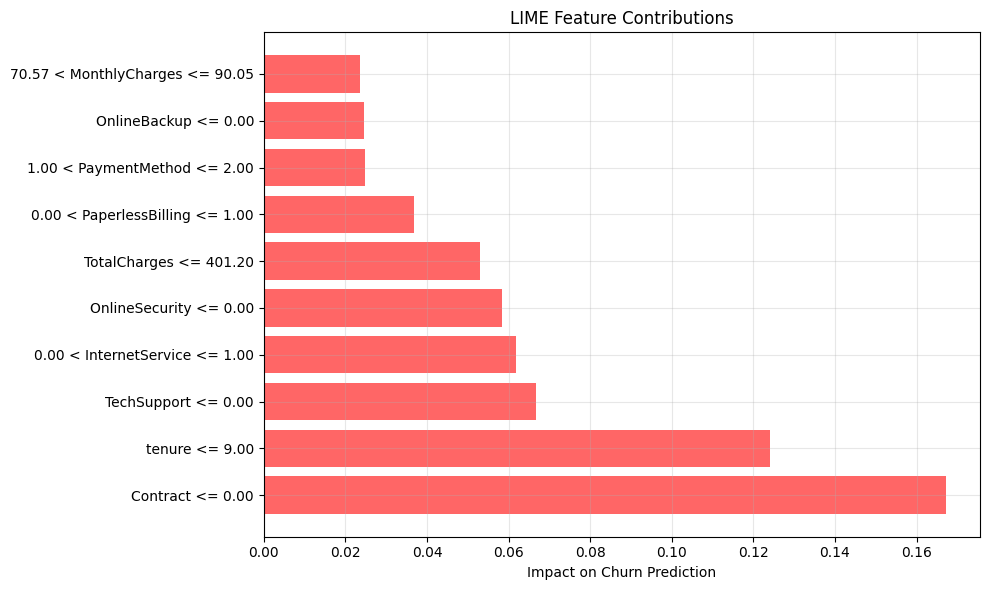

In [29]:
# Perform LIME analysis
print("\n🔬 Generating LIME explanation...\n")

# Ensure feature_names is defined
feature_names = X.columns.tolist()

explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=['No Churn', 'Churn'],
    mode='classification',
    random_state=42
)

explanation = explainer.explain_instance(
    customer_encoded.values[0],
    model.predict_proba,
    num_features=10
)

# Display LIME results
print("=" * 60)
print("LIME FEATURE CONTRIBUTIONS")
print("=" * 60)
print("\nTop 10 features influencing this prediction:\n")

for i, (feature, weight) in enumerate(explanation.as_list(), 1):
    direction = "increases" if weight > 0 else "decreases"
    icon = "🔴" if weight > 0 else "🟢"
    print(f"{i:2d}. {icon} {feature}")
    print(f"    {direction} churn risk by {abs(weight):.3f}")

print("\n" + "=" * 60)
print("INTERPRETATION:")
print("🔴 Positive values = push toward CHURN")
print("🟢 Negative values = push toward RETENTION")
print("=" * 60)

# Visualize LIME weights
features = [item[0] for item in explanation.as_list()]
weights = [item[1] for item in explanation.as_list()]
colors = ['red' if w > 0 else 'green' for w in weights]

plt.figure(figsize=(10, 6))
plt.barh(features, weights, color=colors, alpha=0.6)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Impact on Churn Prediction')
plt.title('LIME Feature Contributions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Claude AI Business Insights

In [26]:
# Prepare context for Claude
lime_text = "\n".join([f"{feature}: {weight:.3f}" for feature, weight in explanation.as_list()])

context = f"""
I have a customer churn prediction for a specific customer:

PREDICTION: {'Churn' if prediction == 1 else 'No Churn'}
PROBABILITY: {churn_prob:.1%}

LIME FEATURE CONTRIBUTIONS:
{lime_text}

Please provide:
1. A clear explanation of why this customer is predicted to churn (or stay)
2. The top 3 risk factors (if churning) or retention factors (if staying)
3. Specific actionable recommendations for this customer
"""

# Ask Claude
print("\n🧠 Asking Claude for business insights...\n")

client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

response = client.messages.create(
    model="claude-sonnet-4-20250514",
    max_tokens=1500,
    messages=[
        {"role": "user", "content": context}
    ]
)

print("=" * 60)
print("CLAUDE AI INSIGHTS")
print("=" * 60)
print(response.content[0].text)
print("=" * 60)


🧠 Asking Claude for business insights...

CLAUDE AI INSIGHTS
## Churn Prediction Analysis

### 1. Why This Customer is Predicted to **STAY**

This customer has a **very low 10.3% churn probability**, meaning they are predicted to remain with the company. The prediction is driven by several strong retention factors that significantly outweigh the minor risk factors.

### 2. Top 3 Retention Factors

**1. Long-term Contract Commitment (-0.149)**
- The customer has a contract longer than 1 year (likely 2-year contract)
- This is the strongest retention factor, showing high commitment to the service

**2. High Tenure (-0.084)**
- Customer has been with the company for over 56 months (4.7+ years)
- Long-standing customers typically have established usage patterns and switching costs

**3. Moderate Monthly Charges (-0.052)**
- Monthly charges between $35.50-$70.57 represent good value perception
- Not in the high-price bracket that often triggers churn

### 3. Actionable Recommendations

###

## Summary

This notebook demonstrated:
- **AI Task 1**: Random Forest classification for customer churn prediction with high accuracy
- **AI Task 2**: Claude LLM for business insights combined with LIME explainability

The combination provides:
1. Accurate predictions of customer churn
2. Explainable AI showing which features drive predictions
3. Business-focused recommendations for action